In [5]:
import numpy as np
import pylab as plt
from simulate_network import run_simulation, plot_LFP
%matplotlib inline
import numpy as np
import scipy.linalg as spl
import scipy.stats as stt
import matplotlib.pyplot as plt

try:
    # import the pyMOU library if already installed
    import pymou as pm
    import pymou.tools as pmt
except:
    # install pyMOU from github and then import otherwhise
    !pip install git+https://github.com/mb-BCA/pyMOU.git@master
    import pymou as pm
    import pymou.tools as pmt

# Set to true if the network connectivity estimation is informed with the topology of the original connectivity
use_topology = False

In [8]:
data = run_simulation(t_sim=1000, stim_strength=50, stim_start=500, stim_dur=10, population=0)

Run spiking neural network...
Collect data from file...
	Population 1/8
	Population 2/8
	Population 3/8
	Population 4/8
	Population 5/8
	Population 6/8
	Population 7/8
	Population 8/8


<Figure size 640x480 with 0 Axes>

# Toy model for estimation of connectivity in MOU process

This Python notebook estimates the connectivity matrix from the observed activity generated by a MOU process.

We first use the MOU class to generate time series with a given connectivity and then aim to recover this original connectivity from the observed time series.

Import libraries and set global options for the simulation/estimation configuration.

## Simulation

In [38]:
# Set ts_sim to data that was generated using run_simulation
(N, T) = data.shape # time in seconds
ts_sim = np.transpose(data)

# masks for matrices (connectivity and covariance)
mask_diag = np.eye(N, dtype=bool)
mask_offdiag = np.logical_not(mask_diag)

# generate matrix for original connectivity. This has to be uniform, as there is structural connectivity everywhere
C_orig = np.ones((N, N)) * 0.1

# generate diagonal matrix with inhomogeneous values for input covariances
Sigma_orig = np.eye(N) * ( np.random.rand(N) * 0.5 + 0.5 )

# create MOU process with C_orig and Sigma_orig
mou_orig = pm.MOU(C=C_orig, Sigma=Sigma_orig)

We plot the MOU activity, as well as the the original connectivity used to generate it.

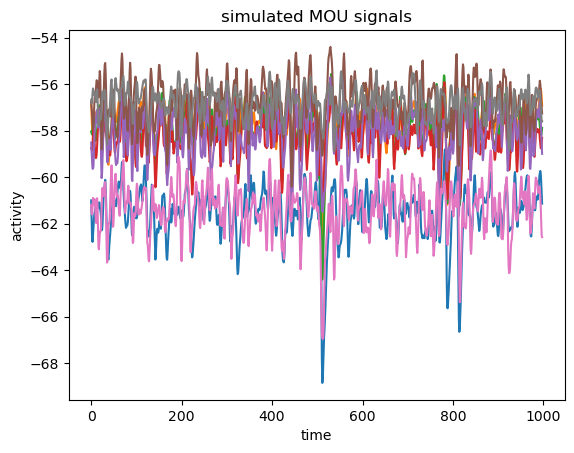

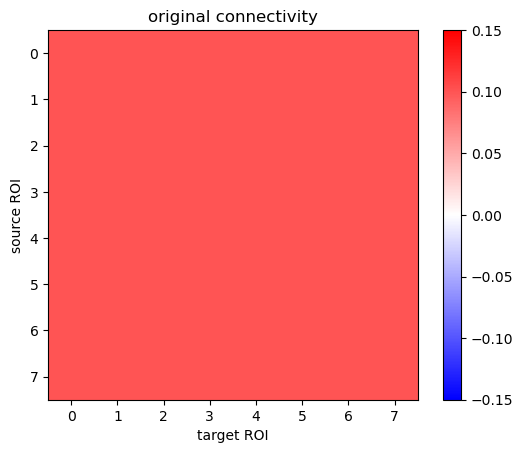

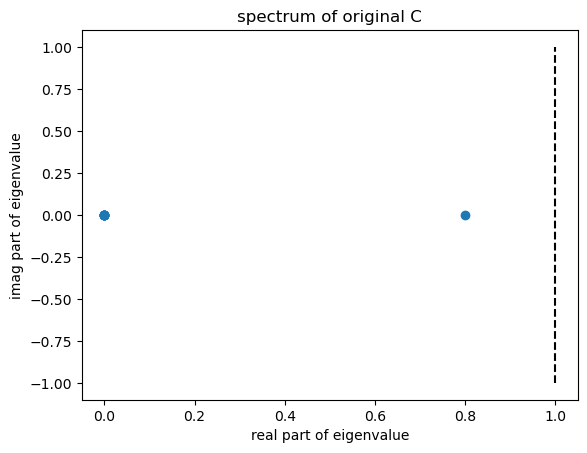

In [39]:
# plot of activity
plt.figure()
plt.plot(range(T),ts_sim)
plt.xlabel('time')
plt.ylabel('activity')
plt.title('simulated MOU signals')

# matrix plot of original connectivity
vmax = np.abs(C_orig).max() * 1.5

plt.figure()
plt.imshow(C_orig, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('original connectivity')

# spectrum of original connectivity
D = np.linalg.eigvals(C_orig)
plt.figure()
plt.scatter(np.real(D),np.imag(D))
plt.plot([1,1],[-1,1],'--k')
plt.xlabel('real part of eigenvalue')
plt.ylabel('imag part of eigenvalue')
plt.title('spectrum of original C')

plt.show()

We compare the match between the simulated and theoretical covariances (the larger the simulation duration $T$, the better the fit).

Q0 fit with theory: PearsonRResult(statistic=0.09010319626521475, pvalue=0.47890746231405773)
Q1 fit with theory: PearsonRResult(statistic=0.13571618325019089, pvalue=0.2849402085386376)



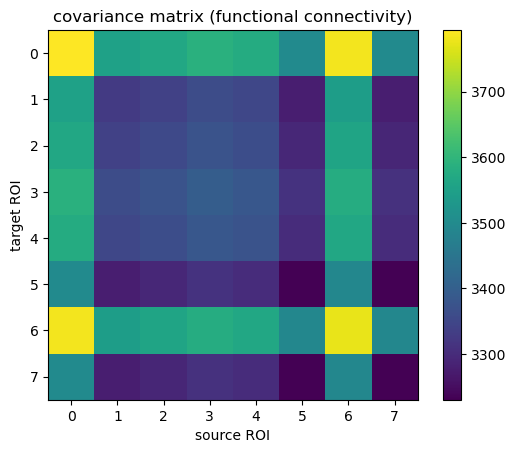

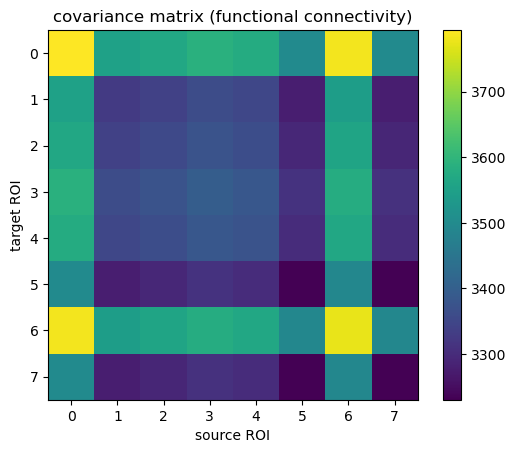

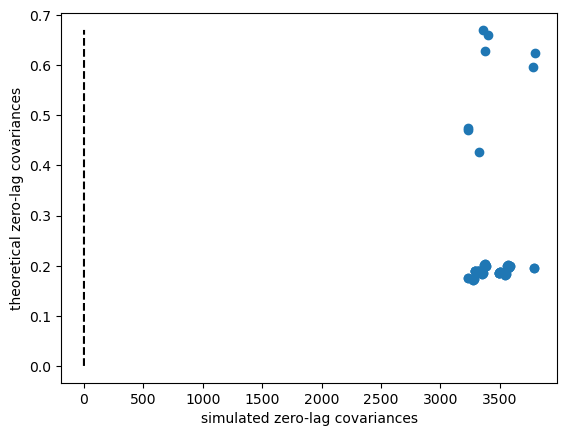

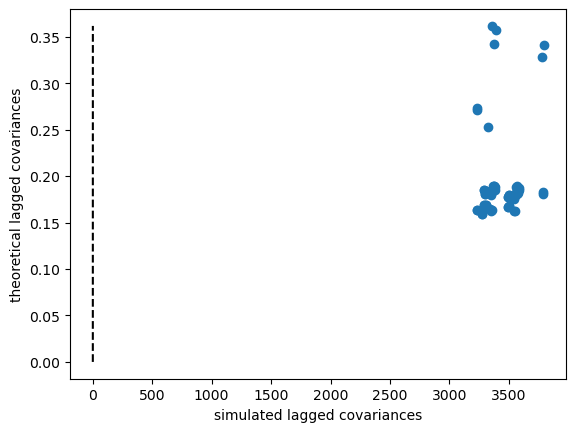

In [40]:
Q0_sim = np.tensordot(ts_sim[0:T-1,:],ts_sim[0:T-1,:],axes=(0,0)) / (T-2)
Q1_sim = np.tensordot(ts_sim[0:T-1,:],ts_sim[1:T,:],axes=(0,0)) / (T-2)

J_orig = -np.eye(N) + C_orig
Q0_th = spl.solve_continuous_lyapunov(J_orig.T, -Sigma_orig)
Q1_th  = np.dot(Q0_th , spl.expm(J_orig))

# fit as measured by the Pearson correlation between the vectorized matrices
print('Q0 fit with theory:', stt.pearsonr(Q0_sim.flatten(), Q0_th.flatten()))
print('Q1 fit with theory:', stt.pearsonr(Q1_sim.flatten(), Q1_th.flatten()))
print()

# plots
plt.figure()
plt.imshow(Q0_sim)
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('covariance matrix (functional connectivity)')

plt.figure()
plt.imshow(Q1_sim)
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('covariance matrix (functional connectivity)')

plt.figure()
plt.plot([0,Q0_th.max()],[0,Q0_th.max()],'--k')
plt.scatter(Q0_sim, Q0_th)
plt.xlabel('simulated zero-lag covariances')
plt.ylabel('theoretical zero-lag covariances')

plt.figure()
plt.plot([0,Q1_th.max()],[0,Q1_th.max()],'--k')
plt.scatter(Q1_sim, Q1_th)
plt.xlabel('simulated lagged covariances')
plt.ylabel('theoretical lagged covariances')

plt.show()

## Connectivity estimation

### Lyapunov optimization

This Lyapunov optimization method is a gradient descent, which iteratively tunes the MOU parameters (C and Sigma) to reproduce the empirical covariances (zero-lag and lagged).

In [41]:
# Lyapunov optimization vanilla style
mou_LO = pm.MOU()
mou_LO.fit(ts_sim, lag=1)

C_LO = np.copy(mou_LO.J)
C_LO[mask_diag] = 0.0

This version of the Lyapunov optimization involves topological constraints on the connectivity estimate (in short, we know which connections exist and they are the same as in the original connectivity). As before, it tunes the time constant tau.

In [42]:
# Lyapunov optimization with topological constraints
mou_LO_topo = pm.MOU()
mou_LO_topo.fit(ts_sim, lag=1, mask_C=C_orig>0, eta_tau=0.05)

C_LO_topo = np.copy(mou_LO_topo.J)
C_LO_topo[mask_diag] = 0.0

This version of the Lyapunov optimization constrains the estimated weights ot be positive (like in the original connectivity). In addition, it tunes the time constant tau that is equivalent to a self-connection for each node (individually for each node).

In [43]:
# Lyapunov optimization with positive constraint on the estimated weights and adapting tau
mou_LO_pos = pm.MOU()
mou_LO_pos.fit(ts_sim, lag=1, min_C=0.0, eta_tau=0.05)

C_LO_pos = np.copy(mou_LO_pos.J)
C_LO_pos[mask_diag] = 0.0

### Moment method

The moment estimation method is a direct calculation involving the matrix logarithm.

In [44]:
# moments method
mou_mom = pm.MOU()
mou_mom.fit(ts_sim, lag=1, method='moments')

C_mom = np.copy(mou_mom.J)
C_mom[mask_diag] = 0.0

### Comparison of estimation methods

We visually compare the estimated connectivity matrices.

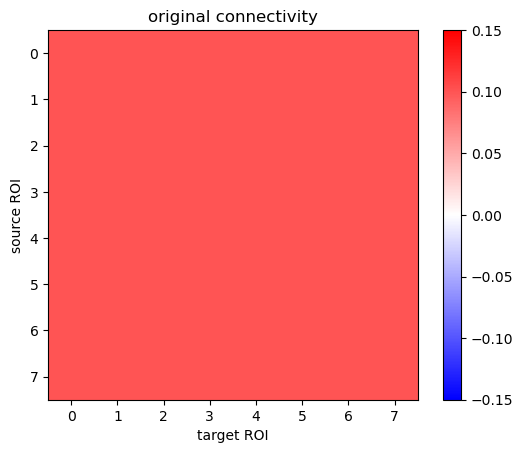

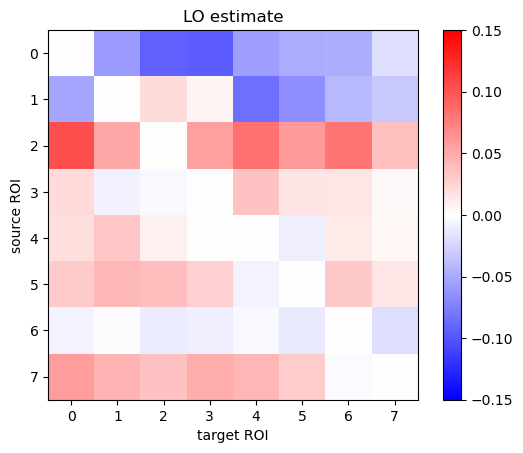

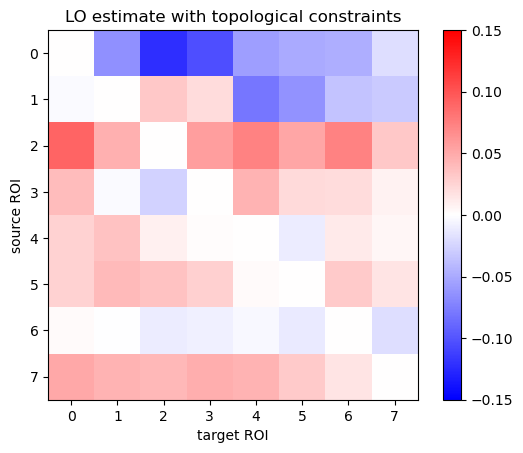

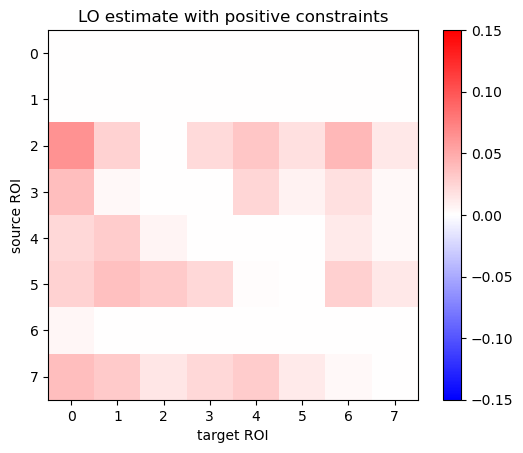

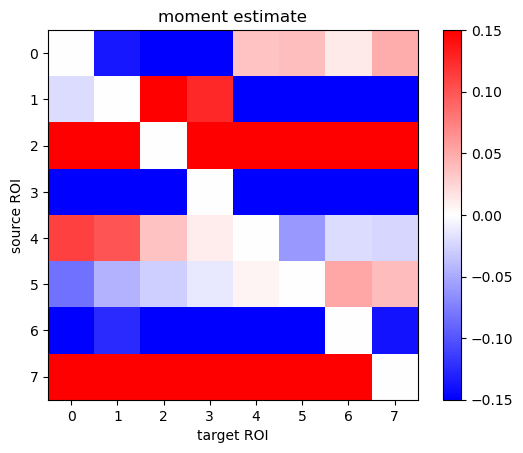

In [45]:
# matrix plots
vmax = np.abs(C_orig).max() * 1.5

plt.figure()
plt.imshow(C_orig, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('original connectivity')

plt.figure()
plt.imshow(C_LO, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('LO estimate')

plt.figure()
plt.imshow(C_LO_topo, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('LO estimate with topological constraints')

plt.figure()
plt.imshow(C_LO_pos, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('LO estimate with positive constraints')

plt.figure()
plt.imshow(C_mom, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('moment estimate')

plt.show()

We plot the estimates against the original (the dashed line indicates a perfect match).

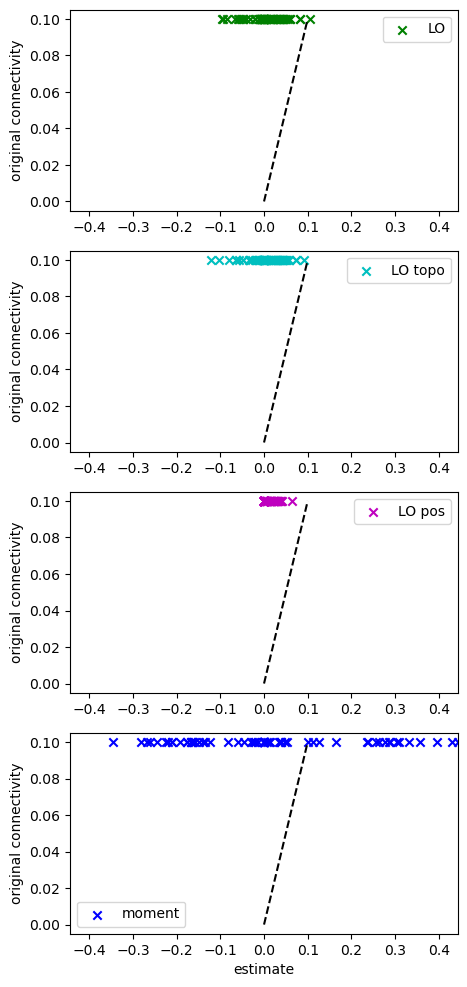

In [46]:
# match between original connectivity and each estimate
vmax = max(np.abs(C_LO).max(), np.abs(C_mom).max())

plt.figure(figsize=[5,12])
plt.subplot(411)
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.scatter(C_LO, C_orig, color='g', marker='x', label='LO')
plt.axis(xmin=-vmax, xmax=vmax)
plt.legend()
plt.ylabel('original connectivity')
plt.subplot(412)
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.scatter(C_LO_topo, C_orig, color='c', marker='x', label='LO topo')
plt.axis(xmin=-vmax, xmax=vmax)
plt.legend()
plt.ylabel('original connectivity')
plt.subplot(413)
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.scatter(C_LO_pos, C_orig, color='m', marker='x', label='LO pos')
plt.axis(xmin=-vmax, xmax=vmax)
plt.legend()
plt.ylabel('original connectivity')
plt.subplot(414)
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.scatter(C_mom, C_orig, color='b', marker='x', label='moment')
plt.axis(xmin=-vmax, xmax=vmax)
plt.legend()
plt.xlabel('estimate')
plt.ylabel('original connectivity')
plt.legend()

plt.show()

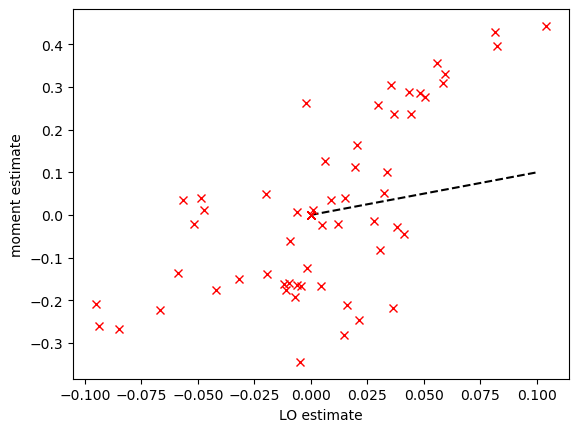

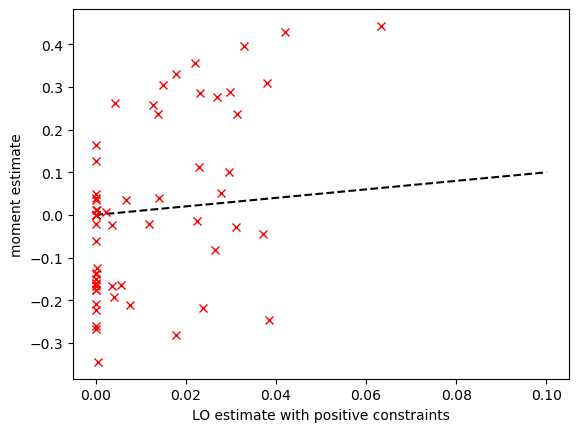

In [47]:
# match between estimates

plt.figure()
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.plot(C_LO,C_mom,'xr')
plt.xlabel('LO estimate')
plt.ylabel('moment estimate')

plt.figure()
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.plot(C_LO_pos,C_mom,'xr')
plt.xlabel('LO estimate with positive constraints')
plt.ylabel('moment estimate')

plt.show()

To compare the estimates in a more quantitative manner, we calculate statistics for the goodness of fit as measured by the Pearson correlation coefficient between the vectorized matrices:
- model versus empirical covariances
- model versus original connectivity

In [48]:
print('- model fit of empirical covariances')
print('LO:',mou_LO.d_fit['correlation'])
print('LO topo:',mou_LO_topo.d_fit['correlation'])
print('LO pos:',mou_LO_pos.d_fit['correlation'])
print('moments:',mou_mom.d_fit['correlation'])
print()
print('- fit with original C')
print('LO:',stt.pearsonr(C_orig.flatten(),C_LO.flatten()))
print('LO topo:',stt.pearsonr(C_orig.flatten(),C_LO_topo.flatten()))
print('LO pos:',stt.pearsonr(C_orig.flatten(),C_LO_pos.flatten()))
print('moments:',stt.pearsonr(C_orig.flatten(),C_mom.flatten()))
print('moments + positive weights:',stt.pearsonr(C_orig.flatten(),np.maximum(C_mom,0).flatten()))

- model fit of empirical covariances
LO: 0.5646597700961327
LO topo: 0.6644242168440377
LO pos: 0.7696552911668593
moments: -0.3072692207107648

- fit with original C
LO: PearsonRResult(statistic=nan, pvalue=nan)
LO topo: PearsonRResult(statistic=nan, pvalue=nan)
LO pos: PearsonRResult(statistic=nan, pvalue=nan)
moments: PearsonRResult(statistic=nan, pvalue=nan)
moments + positive weights: PearsonRResult(statistic=nan, pvalue=nan)


/opt/conda/envs/nest_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:An input array is constant; the correlation coefficient is not defined.


##  Reconstructing the topology of the original connectivity

We calculate the ROC curve for each estimate to evaluate how good is the detection of the existing connections in the original connectivity using the connectivity estimated from the empirical time series.

/tmp/ipykernel_4296/929421172.py:9: RuntimeWarning:invalid value encountered in long_scalars


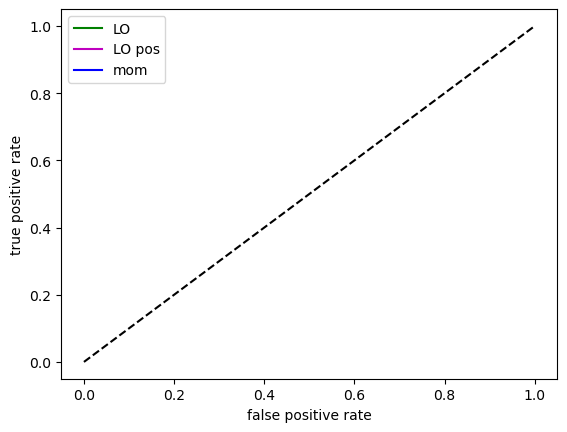

In [49]:
# function to calculate the ROC curve
def ROC(est_M, ref_M):
    # calculate true positive and false positive rates
    n = 100
    TPFP = np.zeros([n,2])
    # move threshold from min to max of est_M
    for i, th in enumerate(np.linspace(est_M.min(), est_M.max(), n)):
        TPFP[i,0] = np.logical_and(est_M>=th, ref_M).sum() / (ref_M).sum()
        TPFP[i,1] = np.logical_and(est_M>=th, np.logical_not(ref_M)).sum() / np.logical_not(ref_M).sum()
    return TPFP

plt.figure()
plt.plot([0,1], [0,1], '--k')
tpfp = ROC(C_LO, C_orig>0)
plt.plot(tpfp[:,1], tpfp[:,0], c='g', label='LO')
tpfp = ROC(C_LO_pos, C_orig>0)
plt.plot(tpfp[:,1], tpfp[:,0], c='m', label='LO pos')
tpfp = ROC(C_mom, C_orig>0)
plt.plot(tpfp[:,1], tpfp[:,0], c='b', label='mom')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

plt.show()

As a sanity check, we calculate the connectivity estimates from the theoretical covariances (i.e. knowing the original connectivity).

In [50]:
# compare with estimates from theoretical covariances
mou_LO_th = pm.MOU()
mou_LO_th.fit_from_cov(Q0_th, Q1_th, lag=1, method='lyapunov', eta_tau=0.05, max_iter=5000)
C_LO_th = np.copy(mou_LO_th.J)
C_LO_th[mask_diag] = 0.0

mou_mom_th = pm.MOU()
mou_mom_th.fit_from_cov(Q0_th, Q1_th, method='moments')
C_mom_th = np.copy(mou_mom_th.J)
C_mom_th[mask_diag] = 0.0

print('- model fit of covariances')
print('LO:',mou_LO_th.d_fit['correlation'])
print('moments:',mou_mom_th.d_fit['correlation'])
print()
print('- fit with original C')
print('LO',stt.pearsonr(C_orig.flatten(),C_LO_th.flatten()))
print('moments',stt.pearsonr(C_orig.flatten(),C_mom_th.flatten()))

- model fit of covariances
LO: 0.9999999999999999
moments: 1.0

- fit with original C
LO PearsonRResult(statistic=nan, pvalue=nan)
moments PearsonRResult(statistic=nan, pvalue=nan)


## Estimated asymmetry

Finally, we compare the asymmetry of the estimates with that of the original connectivity.

In [51]:
# function to calculate the matrix asymmetry
def asym(M):
    return np.abs(M-M.T).sum() / np.abs(M).sum() / 2

print('asym C orig:', asym(C_orig))
print('asym C LO:', asym(C_LO))
print('asym C LO topo:', asym(C_LO_topo))
print('asym C LO pos:', asym(C_LO_pos))
print('asym C mom:', asym(C_mom))
print('asym C LO th:', asym(C_LO_th))
print('asym C mom th:', asym(C_mom_th))

asym C orig: 0.0
asym C LO: 0.776854614310504
asym C LO topo: 0.8307276925444814
asym C LO pos: 0.8111110033865704
asym C mom: 0.7614536225143012
asym C LO th: 4.010680676458379e-14
asym C mom th: 9.813578521240226e-16
